In [149]:
import pandas as pd
import numpy as np



data = pd.read_csv('train.csv')
# print(data)
data = np.array(data)
m ,n = data.shape
np.random.shuffle(data)


# test.shape = (784,1)
# test = np.array(list(map(lambda el:[el], test)))
# print(test)
# test = transform.resize(test, (1, 784))

def min_max_normalize(set : np.array):
    return (set - np.min(set))/(np.max(set) - np.min(set))

# print(data)
data_train = data[0:int(2*m/3)].T
# data_train = data.T
labels_train = data_train[0]
x_train = data_train[1:n]
# print(x_train.shape)
x_train = min_max_normalize(x_train).round()

data_test = data[int(2*m/3):m].T
labels_test = data_test[0]
x_test = data_test[1:n]
x_test = min_max_normalize(x_test).round()

# x_test = x_test.join(test.T)



# x_train = x_train / 255.0
# np.random.shuffle(x_train)
# print(f'labels {labels_train}')
# print(x_train)

# x_train.shape
layer2 = 128
layer3 = 64
def init_params():
    print('initializing...')
    w1 = np.random.rand(layer2,784) - 0.5
    b1 = np.random.rand(layer2,1) - 0.5
    w2 = np.random.rand(layer3,layer2) - 0.5
    b2 = np.random.rand(layer3,1) - 0.5
    w3 = np.random.rand(10,layer3)- 0.5
    b3 = np.random.rand(10,1)- 0.5
    return w1, b1, w2, b2, w3, b3

def RelU(z):
    relU = np.maximum(z, 0)
    return relU

def sigmoid(z):
    e_negx = np.exp(-z)
    sigmoid = 1 / (1 + e_negx)
    return sigmoid

def softmax(z):
    e_z = np.exp(z)
    softmax = e_z/sum(e_z)
    return softmax

def forward_prop(x,w1,b1,w2,b2,w3,b3):
    z1 = w1.dot(x) + b1
    a1 = RelU(z1)
    z2 = w2.dot(a1) + b2
    # a2 = RelU(z2)
    a2 = sigmoid(z2)
    z3 = w3.dot(a2) + b3
    a3 = softmax(z3)
    # print(a2.shape)
    
    return z1, a1, z2, a2, z3, a3


def one_hot(y):
    one_hot = np.zeros((y.size, y.max() + 1))
    one_hot[np.arange(y.size), y] = 1
    one_hot = one_hot.T
    return one_hot

def deriv_RelU(z):
    return z > 0
    # return np.where(z > 0, 1, 0)

def deriv_sigmoid(z):
    sig = sigmoid(z)
    deriv = sig*(1-sig)
    return deriv



def back_prop(a1, w1, z1, a2, w2, z2, a3, w3, z3, x, y):
    one_hot_y = one_hot(y)
    
    m = y.size
#     C0 = np.zeroes(10,1)
    dz3 = a3 - one_hot_y
    # print(error2[0])
    dw3 = dz3.dot(a2.T)/m
    db3 = np.sum(dz3)/m

    # error2 = w3.T.dot(dz3) * deriv_RelU(z2)
    error2 = w3.T.dot(dz3) * deriv_sigmoid(z2)
    dw2 = error2.dot(a1.T)/m
    db2 = np.sum(error2)/m

    error1 = w2.T.dot(error2) * deriv_RelU(z1)
    dw1 = error1.dot(x.T)/m
    db1 = np.sum(error1)/m
    
    return dw1, db1, dw2, db2, dw3, db3


def update_params(w1, b1, w2, b2, w3, b3, dw1, db1, dw2, db2, dw3, db3, rate):
#     print(f'first : w1, b1, w2, b2 : {w1} {b1} {w2} {b2}')
    w1 = w1 - rate * dw1
    b1 = b1 - rate * db1
    w2 = w2 - rate * dw2
    b2 = b2 - rate * db2
    w3 = w3 - rate * dw3
    b3 = b3 - rate * db3
    
#     print(f'changed: w1, b1, w2, b2 : {w1} {b1} {w2} {b2}')

    return w1, b1, w2, b2, w3, b3, dw1, dw2, dw3

def get_predictions(a):
    return np.argmax(a, 0)

def get_accuracy(predictions, y):
    return np.sum(predictions == y)  / y.size, np.sum(y**2-predictions**2) / y.size

# import itertools

def adam(dw, mom_b, vel_b, velocity, momentum, iteration):
    epsilon = 1e-8
    momentum = mom_b*momentum + (1-mom_b)*dw
    velocity = vel_b*velocity + (1-vel_b)*(dw**2)
    m_hat = momentum/(1- mom_b**iteration)
    v_hat = velocity/(1- vel_b**iteration)

    return m_hat/(np.sqrt(v_hat) + epsilon), velocity, momentum
    # return m_hat, v_hat

def adam_gradient_descent(x, y, rate, iteration, vw1, mw1, vw2, mw2, vw3, mw3, w1=None, b1=None, w2=None, b2=None, w3=None, b3=None):
    

    # pdw1, pdw2, pdw3 = dw1, dw2, dw3
    z1, a1, z2, a2, z3, a3 = forward_prop(x, w1, b1, w2, b2, w3, b3)
    dw1, db1, dw2, db2, dw3, db3 = back_prop(a1, w1, z1, a2, w2, z2, a3, w3, z3, x, y)
    
    mom_beta = 0.9
    vel_beta = 0.999
 

    dw1, vw1, mw1 = adam(w1, mom_beta, vel_beta, vw1, mw1, iteration)
    dw2, vw2, mw2 = adam(w2, mom_beta, vel_beta, vw2, mw2, iteration)
    dw3, vw3, mw3 = adam(w3, mom_beta, vel_beta, vw3, mw3, iteration)

    w1, b1, w2, b2, w3, b3, _, _, _ = update_params(w1, b1, w2, b2, w3, b3, dw1, db1, dw2, db2, dw3, db3, rate)

    return w1, b1, w2, b2, w3, b3, a3, vw1, mw1, vw2, mw2, vw3, mw3


def gradient_descent(x, y, rate, momentum=True, decay=.95, w1=None, b1=None, w2=None, b2=None, w3=None, b3=None, dw1=None, dw2=None, dw3=None):
    

    pdw1, pdw2, pdw3 = dw1, dw2, dw3
    z1, a1, z2, a2, z3, a3 = forward_prop(x, w1, b1, w2, b2, w3, b3)
    dw1, db1, dw2, db2, dw3, db3 = back_prop(a1, w1, z1, a2, w2, z2, a3, w3, z3, x, y)
    w1, b1, w2, b2, w3, b3, dw1, dw2, dw3 = update_params(w1, b1, w2, b2, w3, b3, dw1, db1, dw2, db2, dw3, db3, rate)

    if momentum:
        if pdw1 == None:
            pdw1 = 0
            pdw2 = 0
            pdw3 = 0     
        # print(pdw1)
        w1 = w1 - decay*pdw1
        w2 = w2 - decay*pdw2
        w3 = w3 - decay*pdw3

    return w1, b1, w2, b2, w3, b3, a3, dw1, dw2, dw3
# `   34QW2`

def minibatchGD(x, y, epochs, rate, batch_size=128,optimizer='', validation=[], validKey='' ,w1=None, b1=None, w2=None, b2=None, w3=None, b3=None, sudoku=None, key=None):
    xLoss = []
    yAcc = []
    validationLoss = []
    validationAcc = []
    print(y.shape)
    # sudokuLoss = None
    # if sudoku != None:
    # if:
    sudokuLoss = []
    sudokuAcc = []

    load = '----------------------------------------------------------|'
    if not isinstance(w1, np.ndarray):
        w1, b1, w2, b2, w3, b3 = init_params()
    
    for epoch in range(epochs):
        pos = 0
        dw1 = 0
        dw2 = 0
        dw3 = 0
        iteration = 0
        vw1 = np.zeros_like(w1) 
        mw1 = np.zeros_like(w1)
        vw2 = np.zeros_like(w2) 
        mw2 = np.zeros_like(w2)
        vw3 = np.zeros_like(w3) 
        mw3 = np.zeros_like(w3)
        while(pos < batch_size):
            iteration+=1
            batchX = x.T[pos:pos+batch_size].T
            batchY = y.T[pos:pos+batch_size].T
            # batchYpreds = 
            # display(x.shape, batchX.shape)
            # display(y.shape, batchY.shape)
            pos = pos + batch_size
            dist = int((len(load)*epoch)/epochs)
            bar = ['*']*dist
            loader = [*load]
            loader[0:dist] = bar
            load = ''.join(loader)

            # batch = x.T[pos:epoch*batch_size].T
            if optimizer == "adam":
                w1, b1, w2, b2, w3, b3, a3, vw1, mw1, vw2, mw2, vw3, mw3 = adam_gradient_descent(x=batchX, y=batchY, rate=rate, w1=w1, b1=b1, w2=w2, b2=b2, w3=w3, b3=b3,vw1=vw1, mw1=mw1, vw2=vw2, mw2=mw2, vw3=vw3, mw3=mw3, iteration=iteration)
            else:
                w1, b1, w2, b2, w3, b3, a3, dw1, dw2, dw3 = gradient_descent(x=batchX, y=batchY, rate=rate, w1=w1, b1=b1, w2=w2, b2=b2, w3=w3, b3=b3, dw1=dw1, dw2=dw2, dw3=dw3)
            # print(a3.shape, batchY.shape)
            accuracy, loss = get_accuracy(get_predictions(a3), batchY)
            xLoss.append(loss)
            yAcc.append(accuracy)

            acc, val_loss = get_accuracy(make_predictions(validation, w1, b1, w2, b2, w3, b3), validKey)
            validationLoss.append(val_loss)
            validationAcc.append(acc)

            if sudoku is not None:
                sudoku_acc, sudoku_loss = get_accuracy(make_predictions(sudoku, w1, b1, w2, b2, w3, b3), key)
                sudokuLoss.append(sudoku_loss)
                sudokuAcc.append(sudoku_acc)



            if epoch < epochs-1:
                print(f'[{epoch}/{epochs}] {load} {accuracy} {loss}', end='\r')
            else:
                print(f'{load} {accuracy} {loss} complete')

    return w1, b1, w2, b2, w3, b3, np.array(xLoss), np.array(yAcc), np.array(validationLoss), np.array(validationAcc), np.array(sudokuLoss), np.array(sudokuAcc)

def make_predictions(x, w1, b1, w2, b2, w3, b3):
    _, _, _, _, _, a3 = forward_prop(x, w1, b1, w2, b2, w3, b3)
    predictions = get_predictions(a3)
    return predictions

# minibatchGD(x_train, y_label,2,2,2)





In [150]:
from skimage import io, transform, color
import cv2


image = cv2.imread('board.png')
# if image.shape[2] == 4:
#     image = color.rgb2gray(color.rgba2rgb(image))
# else: 
#     image = color.rgb2gray(image)
image = cv2.bitwise_not(image)
# print(np.array(image).shape)

# image = transform.resize(image, (28, 28))

image = color.rgb2gray(image)

def split_grid(image : np.array):
    m, n = image.shape
    one = image[0:int(m/3),0:int(n/3)]
    two = image[0:int(m/3),int(n/3):int(2*n/3)]
    three = image[0:int(m/3),int(2*n/3):n]

    four = image[int(m/3):int(2*m/3),0:int(n/3)]
    five = image[int(m/3):int(2*m/3),int(n/3):int(2*n/3)]
    six = image[int(m/3):int(2*m/3),int(2*n/3):n]

    seven = image[int(2*m/3):int(m),0:int(n/3)]
    eight = image[int(2*m/3):int(m),int(n/3):int(2*n/3)]
    nine = image[int(2*m/3):int(m),int(2*n/3):n]

    return one, two, three, four, five, six, seven, eight, nine

squares = list(split_grid(image))
nine = squares[8]

spaces = list(split_grid(nine))


def get_pixels(image : np.array, show = False):
    image = transform.resize(image, (28, 28))
    pixels = np.array(image.flatten())
    if show: 
        print(pixels)

    return image, np.array([pixels])

# print(image2.shape)
# io.imshow(image2)
# io.show()

In [151]:
directory = 'assets'

import os

# print(picture)
# io.imshow(picture)
# io.show()

def create_entry(pixels : np.array, label : str, set : list):
    pixels = pixels.tolist()[0]
    # print(pixels)
    # print(label, type(pixels))
    pixels.extend([label])
    set.append(pixels)
    
    return pixels, set


In [152]:

digits = []
digit_test = []
print('loading files...')
i = 0
for folder in os.listdir(directory):
    f = os.path.join(directory, folder)
    count = 0


    # print(f)
    for file in os.listdir(f):
        count = count + 1
        if count > 500:
            if os.path.isfile(file_name):
            # print(file_name)
                picture = cv2.imread(file_name)
                picture = color.rgb2gray(picture)

                _, pixels = get_pixels(picture)
                pixels = pixels
                label = int(file_name[7])
                _, digit_test = create_entry(pixels, label, digit_test)
                continue

        picture = None
        file_name = os.path.join(f, file)
        # print(file)
        if os.path.isfile(file_name):
            # print(file_name)
            picture = cv2.imread(file_name)
            picture = color.rgb2gray(picture)

            _, pixels = get_pixels(picture)
            pixels = pixels
            label = int(file_name[7])
            _, digits = create_entry(pixels, label, digits)

    print(f'{i} : {count} entries')
    i = i+1



                # print(digits)
                # io.imshow()
                # io.show()
                # print(label, len(entry))

digits = np.array(digits)
digit_test = np.array(digit_test)
print(digits.shape)
print(digit_test.shape)


# one = digits[0:2]




loading files...
0 : 514 entries
1 : 750 entries
2 : 769 entries
3 : 626 entries
4 : 649 entries
5 : 731 entries
6 : 548 entries
7 : 710 entries
8 : 585 entries
9 : 583 entries
(5000, 785)
(1465, 785)


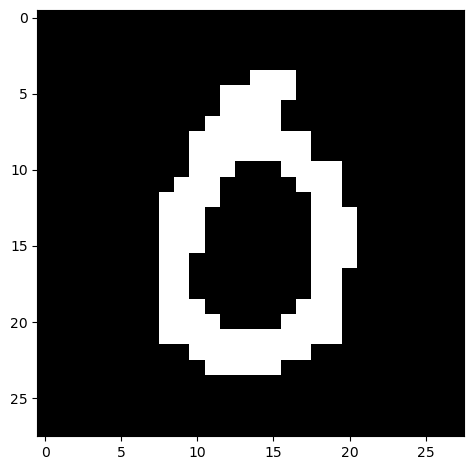

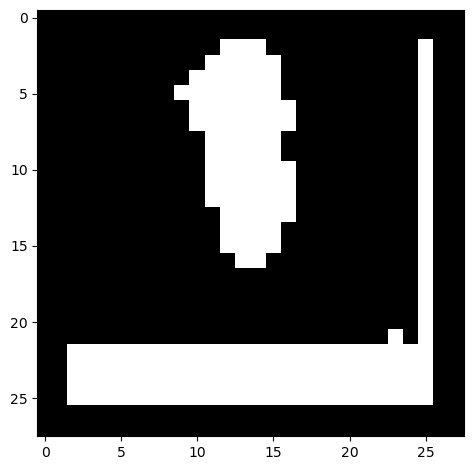

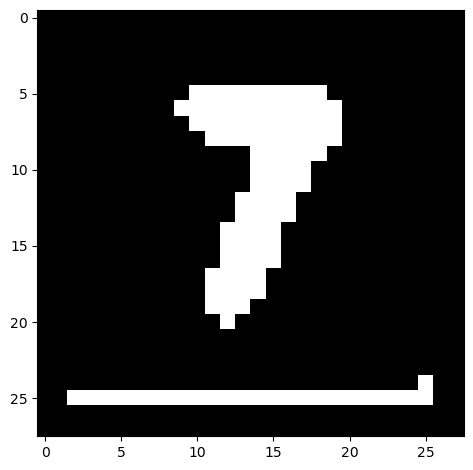

In [153]:
np.random.shuffle(digits)
np.random.shuffle(digit_test)
m, n = digits.shape
digits = digits.round()
digit_train = digits.T
digit_labels = digit_train[-1]
x_digit_train = digit_train[0:n-1]
first_digit = x_digit_train[:,-1]
first = x_train[:,1]

m, n = digit_test.shape
digit_test = digit_test.round()
test_digits = digit_test.T
digit_test_labels = test_digits[-1]
x_digit_test = test_digits[0:n-1]

first_digit_test = x_digit_test[:,-1]
# display(first_digit_test, first_digit_test.shape)

# x_digit_train = min_max_normalize(digit_train[0:n-1])
# print(first_digit[first_digit != 0], first[first != 0], first_digit.shape == first.shape)
# first = first.round()
io.imshow(first.reshape(28,28))
io.show()
io.imshow(first_digit.reshape(28,28))
io.show()
io.imshow(first_digit_test.reshape(28,28))
io.show()

test = np.array(pd.read_csv('test.csv')).T
test = min_max_normalize(test)


In [154]:

def add_to_test(test, pixels):
    # print('added')
    return np.append(test, pixels.T, 1)

grid_labels = np.array([0, 7, 0, 0, 0, 0,0,3,0,8,3,0,4,0,0,0,0,0,0,4,1,0,0,7,0,0,0,0,4,0,0,2,1,0,0,5,7,0,0,3,0,0,0,0,0,0,6,0,4,0,8,0,0,0,9,0,0,0,0,8,0,0,0,0,0,5,0,0,0,0,0,0,2,8,0,0,0,0,1,0,9])
print(len(grid_labels))
def format_board(test):
    image = cv2.imread('board.png')
    image = cv2.bitwise_not(image)

    image = color.rgb2gray(image)
    # image = image.round()

    io.imshow(image)
    io.show()

    grids = list(split_grid(image))
    mini_grids = []
    for grid in grids:
        spaces = list(split_grid(grid))
        mini_grids.append(spaces)
        for space in spaces:
            # io.imshow(space)
            # io.show()
            # label = grid_labels[i]
            test = add_to_test(test, get_pixels(space)[1])

    return mini_grids, test


81


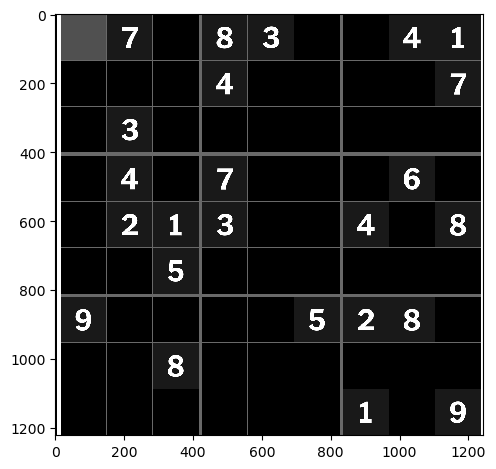

(784, 81)


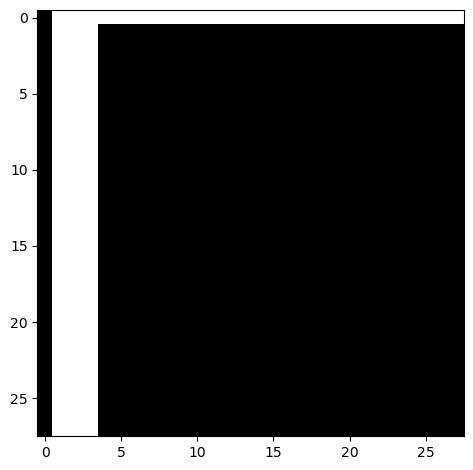

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 784


In [155]:

# print('test size' , test.shape)
grids, test = format_board(test)
# print(grids)
# print('test size' , test.shape)
m, n = test.shape
board_squares = test[:, 28000:n]
print(board_squares.shape)
board_squares = board_squares.round()
# io.imshow(board_squares.reshape())
io.show()
space = board_squares[:,0]
io.imshow(space.reshape(28,28))
io.show()

print(space[space != 0], len(board_squares[:,0]))


(784, 28000)
[1 0 0 ... 8 5 3]
(28000,)
initializing...
**********************************************************| 0.08978571428571429 2.320607142857143 complete45


array([5, 5, 5, ..., 5, 5, 5], dtype=int64)

array([9, 5, 7, ..., 2, 9, 1], dtype=int64)

test accuracy : (0.08378571428571428, 2.3384285714285715)


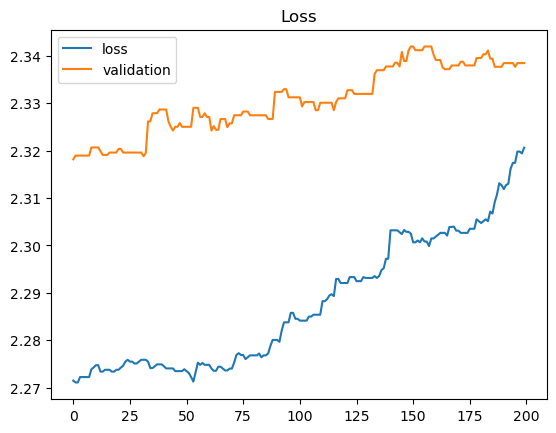

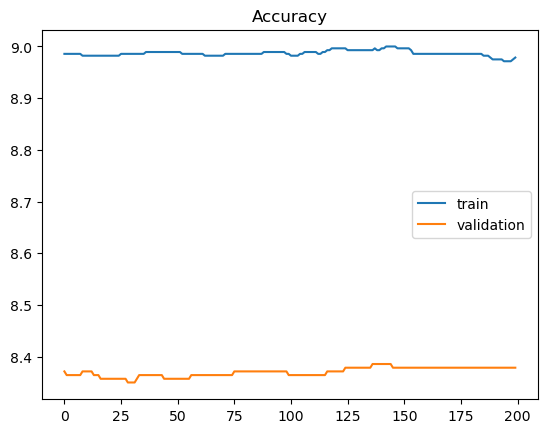

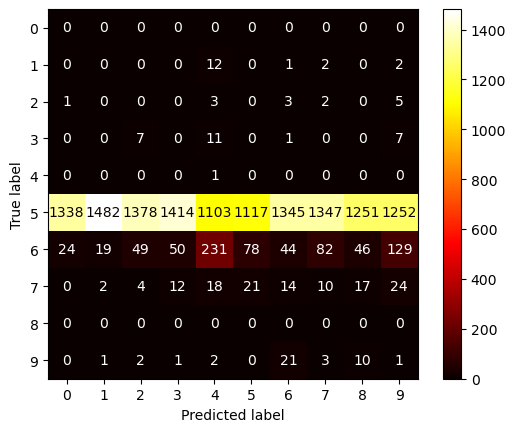

In [156]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

mnist_rate = 5e-5
# iters = 500
# iters = 80
print(x_train.shape)

print(labels_train)
w1, b1, w2, b2, w3, b3, lossY, accY, validationLoss, validationAcc, _, _ = minibatchGD(x=x_train, y=labels_train,  epochs=200, rate=mnist_rate, batch_size=int(x_train.shape[1]), optimizer="adam", validation=x_test, validKey=labels_test)
# w1, b1, w2, b2, w3, b3, lossY, accY, validationLoss, validationAcc, _, _ = minibatchGD(x=x_train, y=labels_train, epochs=400, batch_size=256, optimizer="adam", rate=mnist_rate, validation=x_test, validKey=labels_test)

preds = make_predictions(x_test, w1, b1, w2, b2, w3, b3)
display(preds)
display(labels_test)
mnist_acc, mnist_loss = get_accuracy(preds, labels_test)
print(f'test accuracy : {get_accuracy(preds, labels_test)}')

# display(lossY)
plt.plot(lossY, label='loss')
plt.plot(validationLoss, label='validation')
plt.title('Loss')
plt.legend()
plt.show()
plt.plot(accY*100, label='train')
plt.plot(validationAcc*100, label='validation')
plt.legend()
plt.title('Accuracy')
plt.show()

# firstY = 

confusion = confusion_matrix(preds, labels_test)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=[0,1,2,3,4,5,6,7,8,9])
disp.plot(cmap='hot')


# prev : 800



# # print(w1, b1, w2, b2, w3, b3)


In [157]:
digit_rate = .08
w1, b1, w2, b2, w3, b3, digiLossY, accY, validationLoss, validationAcc, sudokuLoss, sudokuAcc = minibatchGD(x=x_digit_train, y=digit_labels.astype(int), epochs=200, batch_size=int(x_digit_train.shape[1]),optimizer="adam",validation=x_digit_test, rate=digit_rate, w1=w1, b1=b1, w2=w2, b2=b2, w3=w3, b3=b3,sudoku=board_squares, key=grid_labels, validKey=digit_test_labels)
# w1, b1, w2, b2, w3, b3, digiLossY, accY, validationLoss, validationAcc, sudokuLoss, sudokuAcc = minibatchGD(x=x_digit_train, y=digit_labels.astype(int), epochs=500, batch_size=128, validation=x_digit_test, validKey=digit_test_labels, rate=digit_rate, w1=w1, b1=b1, w2=w2, b2=b2, w3=w3, b3=b3, sudoku=board_squares, key=grid_labels)
# w1, b1, w2, b2, w3, b3, digiLossY2, accY2 = gradient_descent(x_digit_train, digit_labels.astype(int), 1000, digit_rate-.01, w1, b1, w2, b2, w3, b3)
# w1, b1, w2, b2, w3, b3, digiLossY3, accY3 = gradient_descent(x_digit_train, digit_labels.astype(int), 300, .07, w1, b1, w2, b2, w3, b3)
preds = make_predictions(x_digit_test, w1, b1, w2, b2, w3, b3)

print(f'test accuracy : {get_accuracy(preds, digit_test_labels)}')

# plt.plot(digiLossY, label='train')
# plt.plot(validationLoss, label='validation')
# plt.plot(sudokuLoss, label='sudoku')
# plt.legend()
# plt.title('Loss')
# plt.show()
# plt.plot(accY*100, label='train')
# plt.plot(validationAcc*100,label='validation')
# plt.plot(sudokuAcc*100,label='suoko')
# plt.legend()
# plt.title('Accuracy')
# plt.show()



(5000,)
**********************************************************| 0.1 27.5 complete-0.6852
test accuracy : (0.032764505119453925, -7.288054607508532)


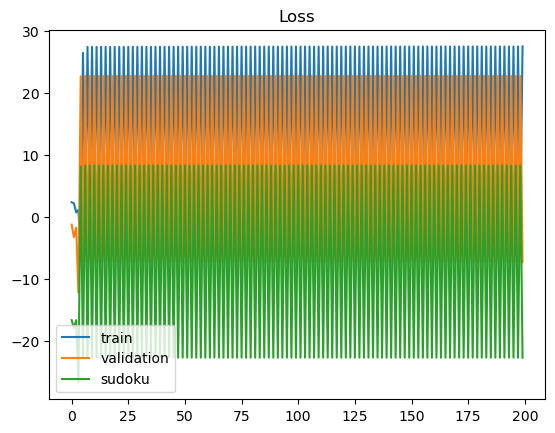

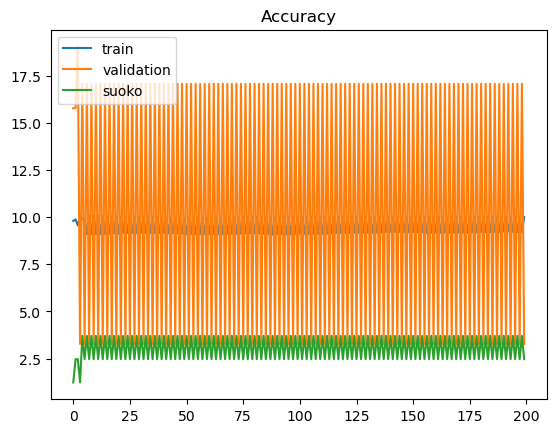

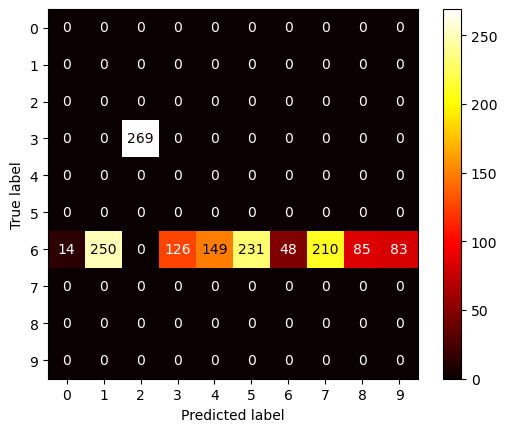

In [158]:
plt.plot(digiLossY, label='train')
plt.plot(validationLoss, label='validation')
plt.plot(sudokuLoss, label='sudoku')
plt.legend()
plt.title('Loss')
plt.show()
plt.plot(accY*100, label='train')
plt.plot(validationAcc*100,label='validation')
plt.plot(sudokuAcc*100,label='suoko')
plt.legend()
plt.title('Accuracy')
plt.show()


confusion = confusion_matrix(preds, digit_test_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=[0,1,2,3,4,5,6,7,8,9])
disp.plot(cmap='hot')

[6 3 6 6 6 6 6 6 6 3 3 6 6 6 6 6 6 6 6 3 6 6 6 6 6 6 6 6 6 6 6 3 6 6 6 3 3
 6 6 3 6 6 6 6 6 6 3 6 6 6 6 6 6 6 6 6 6 6 6 3 6 6 6 6 6 3 6 6 6 6 6 6 3 6
 6 6 6 6 6 6 6] 
 [0 7 0 0 0 0 0 3 0 8 3 0 4 0 0 0 0 0 0 4 1 0 0 7 0 0 0 0 4 0 0 2 1 0 0 5 7
 0 0 3 0 0 0 0 0 0 6 0 4 0 8 0 0 0 9 0 0 0 0 8 0 0 0 0 0 5 0 0 0 0 0 0 2 8
 0 0 0 0 1 0 9]
test accuracy : 2.47%, -22.70 loss


array([[False, False, False, False, False, False, False, False, False],
       [False,  True, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False,  True, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False]])

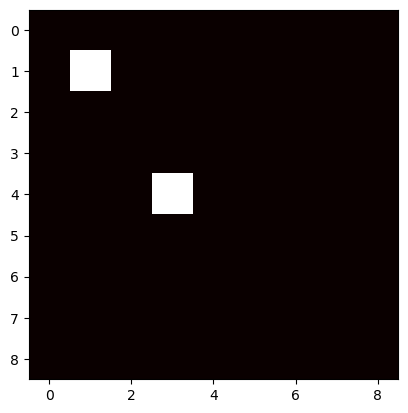

{'hiddenlayer1 neurons': 128, 'hiddenlayer2 neurons': 64, 'mnist learning rate': 5e-05, 'digits learning rate': 0.08, 'mnist final accuracy': 0.08378571428571428, 'mnist loss': 2.3384285714285715, 'digit final accuracy': 0.1, 'digit loss': -22.703703703703702, 'puzzle accuracy': 0.024691358024691357}


In [159]:

preds = make_predictions(board_squares, w1, b1, w2, b2, w3, b3)
print(f'{preds} \n {grid_labels}')
digit_acc, digit_loss = get_accuracy(preds, grid_labels)
# print(preds == grid_labels)
print(f'test accuracy : {digit_acc*100:.2f}%, {digit_loss:.2f} loss')
indexes = [j + 1 for j in range(preds.shape[0])]
# predsCount = preds.count_nonzero()
# gridCount = grid_labels.count_nonzero()
# display(predsCount)
# display(gridCount)
# 2
map = (preds == grid_labels).reshape(9,9)
display(map)
formatted = zip(indexes, preds)
submission = pd.DataFrame(formatted, columns = ['ImageID', 'Label'])

# np.savetxt('puzzle_accuracy.csv',np.array([grid_accuracy]), fmt='%.2f')
    
submission.to_csv('puzzle.csv', index=False)
plt.imshow(map, cmap='hot')
plt.show()


results = {
    'hiddenlayer1 neurons' : layer2,
    'hiddenlayer2 neurons' : layer3,
    'mnist learning rate' : mnist_rate,
    'digits learning rate' : digit_rate,
    'mnist final accuracy' : mnist_acc,
    'mnist loss' : mnist_loss,
    'digit final accuracy' : accY[-1],
    'digit loss' : digit_loss,
    'puzzle accuracy' : digit_acc
}


# preds = make_predictions(x_test, w1, b1, w2, b2, w3, b3)
# display(preds) 
# print(len(preds))
# print(len(labels_test))
# display(labels_test)


print(results)
data = pd.DataFrame([results], columns=None)

data.to_csv('training.csv', mode='a')

# display(pd.DataFrame(w1, columns=None))

# weights.to_csv('weights.csv', index = False)


# best 97% : 1st train .1, 600, 2nd train .15, 800 , and rounded values for both sets

# 95% 97% : 1st train .12, 700, 2nd train .15, 1300 , and rounded values for both sets


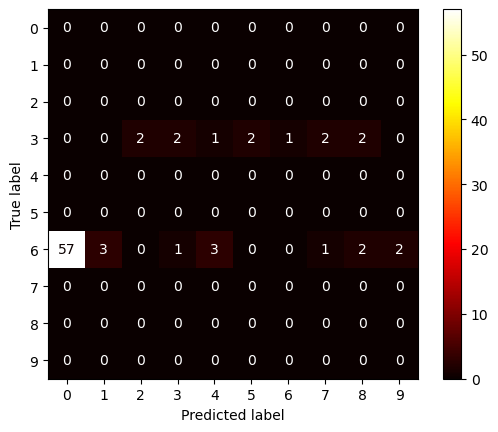

In [160]:
# pd.DataFrame(w1).to_csv('data/params/w1.csv', index=False)
# pd.DataFrame(b1).to_csv('data/params/b1.csv', index=False)
# pd.DataFrame(w2).to_csv('data/params/w2.csv', index=False)
# pd.DataFrame(b2).to_csv('data/params/b2.csv', index=False)
# pd.DataFrame(w3).to_csv('data/params/w3.csv', index=False)
# pd.DataFrame(b3).to_csv('data/params/b3.csv', index=False)
# display(b1)
# preds = [0 , 1, 2, 4, 5, 7, 2, 5, 8,5 ,3]
# grid_labels = [2,3,5,3,5,5,6,3,8,5]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion = confusion_matrix(preds, grid_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=[0,1,2,3,4,5,6,7,8,9])
disp.plot(cmap='hot')


# disp.plot(c)
# plt.imshow(confusion, cmap='hot')
# plt.show()

In [161]:
training = pd.read_csv('data/results/training.csv')
display(training)

,Unnamed: 0,hiddenlayer1 neurons,hiddenlayer2 neurons,mnist learning rate,digits learning rate,mnist final accuracy,mnist loss,digit final accuracy,digit loss,puzzle accuracy
0,0.0,52,52,0.04,0.03,0.8852380952380953,-0.056857142857142856,0.6799740344044142,-1.0987654320987654,0.9135802469135802
1,NaN,hiddenlayer1 neurons,hiddenlayer2 neurons,mnist learning rate,digits learning rate,mnist final accuracy,mnist loss,digit final accuracy,digit loss,puzzle accuracy
2,0.0,52,28,0.04,0.03,0.8672380952380953,0.15276190476190477,0.6471924699772801,-3.814814814814815,0.9135802469135802
3,NaN,hiddenlayer1 neurons,hiddenlayer2 neurons,mnist learning rate,digits learning rate,mnist final accuracy,mnist loss,digit final accuracy,digit loss,puzzle accuracy
4,0.0,52,28,0.03,0.03,0.8562857142857143,0.23457142857142857,0.6815968841285297,-1.8148148148148149,0.9135802469135802
...,...,...,...,...,...,...,...,...,...,...
154,0.0,32,16,0.05,0.09,0.8182142857142857,0.6214285714285714,0.8104,-2.6296296296296298,0.8395061728395061
155,NaN,hiddenlayer1 neurons,hiddenlayer2 neurons,mnist learning rate,digits learning rate,mnist final accuracy,mnist loss,digit final accuracy,digit loss,puzzle accuracy
156,0.0,64,32,0.05,0.09,0.8982857142857142,0.10728571428571429,0.8994,-0.43209876543209874,0.9382716049382716
157,NaN,hiddenlayer1 neurons,hiddenlayer2 neurons,mnist learning rate,digits learning rate,mnist final accuracy,mnist loss,digit final accuracy,digit loss,puzzle accuracy


In [162]:
# preds = make_predictions(board_squares, w1, b1, w2, b2, w3, b3)
# print(f'{preds} \n {grid_labels}')
# grid_accuracy = get_accuracy(preds, grid_labels)
# # print(preds == grid_labels)
# print(f'test accuracy : {grid_accuracy}')
# indexes = [j + 1 for j in range(preds.shape[0])]

# map = (preds == grid_labels).reshape(9,9)
# display(map)
# display(grid_labels.reshape(9,9))
# preds = zip(indexes, preds)
# submission = pd.DataFrame(preds, columns = ['ImageID', 'Label'])

# np.savetxt('data/results/puzzle_accuracy.csv',np.array([grid_accuracy]), fmt='%.2f')
    
# submission.to_csv('puzzle.csv', index=False)
# plt.imshow(map, cmap='hot')
# plt.show()